In [30]:
import zipfile
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from PIL import Image
from functools import reduce

In [2]:
IMG_WIDTH = 32
IMG_HEIGHT = 32

In [3]:
def reduce_file_into_data(data, filename, zfile):
    try:
        label = int(re.match(r"gtsrb/(\d+)/(.*?).ppm", filename).group(1))
    except AttributeError:
        return data

    with zfile.open(filename) as file:
        img = np.array(Image.open(file).resize((IMG_WIDTH, IMG_HEIGHT)))

    X, y = data

    X.append(img)
    y.append(label)

    return data


with zipfile.ZipFile("./gtsrb.zip") as zfile:
    X, y = reduce(
        lambda *args: reduce_file_into_data(*args, zfile), zfile.namelist(), ([], [])
    )

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array(X), np.array(y), test_size=0.1, random_state=0
)

In [16]:
model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        keras.layers.Rescaling(1.0 / 255),
        keras.layers.Conv2D(
            filters=6,
            kernel_size=5,
            activation="relu",
        ),
        keras.layers.AvgPool2D(
            pool_size=2,
            strides=2,
        ),
        keras.layers.Conv2D(
            filters=16,
            kernel_size=5,
            activation="relu",
        ),
        keras.layers.AvgPool2D(
            pool_size=2,
            strides=2,
        ),
        keras.layers.Conv2D(
            filters=120,
            kernel_size=5,
            activation="relu",
        ),
        keras.layers.Flatten(),
        keras.layers.Dense(84, activation="relu"),
        keras.layers.Dense(len(set(y_train)), activation="softmax"),
    ]
)

In [17]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 6)         456       
                                                                 
 average_pooling2d_6 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_10 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_7 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_11 (Conv2D)          (None, 1, 1, 120)        

In [28]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    X_train,
    keras.utils.to_categorical(y_train),
    epochs=10,
    batch_size=128,
)

Epoch 1/10
188/188 [==============================] - 2s 9ms/step - loss: 0.0034 - accuracy: 0.9989
Epoch 2/10
188/188 [==============================] - 2s 9ms/step - loss: 0.0040 - accuracy: 0.9990
Epoch 3/10
188/188 [==============================] - 2s 9ms/step - loss: 0.0034 - accuracy: 0.9990
Epoch 4/10
188/188 [==============================] - 2s 11ms/step - loss: 0.0059 - accuracy: 0.9984
Epoch 5/10
188/188 [==============================] - 2s 12ms/step - loss: 8.6485e-04 - accuracy: 0.9999
Epoch 6/10
188/188 [==============================] - 3s 13ms/step - loss: 0.0011 - accuracy: 0.9996
Epoch 7/10
188/188 [==============================] - 3s 14ms/step - loss: 9.4484e-05 - accuracy: 1.0000
Epoch 8/10
188/188 [==============================] - 2s 11ms/step - loss: 6.0474e-05 - accuracy: 1.0000
Epoch 9/10
188/188 [==============================] - 3s 13ms/step - loss: 4.7220e-05 - accuracy: 1.0000
Epoch 10/10
188/188 [==============================] - 3s 15ms/step - loss: 3.

In [29]:
model.evaluate(
    X_test,
    keras.utils.to_categorical(y_test),
)

84/84 [==============================] - 0s 4ms/step - loss: 0.0942 - accuracy: 0.9914


[0.09415392577648163, 0.9913663864135742]

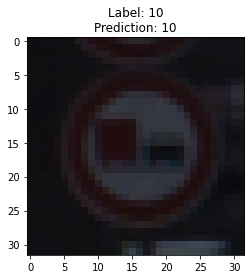

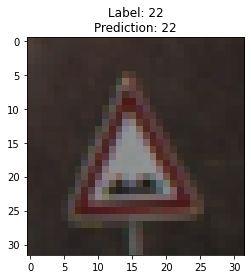

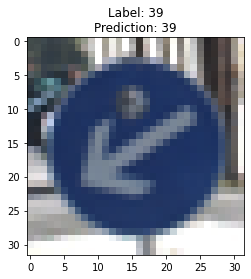

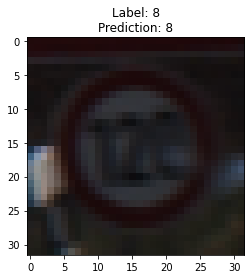

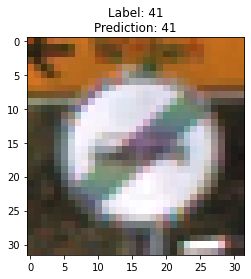

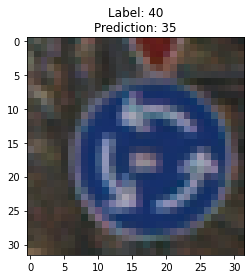

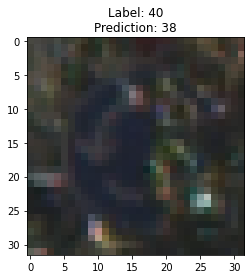

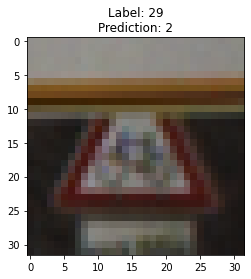

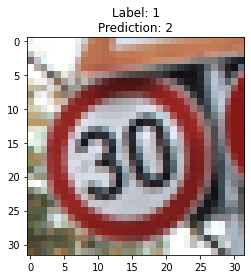

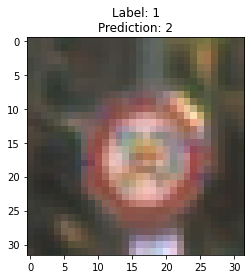

In [51]:
correctly_classified = []
incorrectly_classified = []

while len(correctly_classified) < 5 or len(incorrectly_classified) < 5:
    random_index = np.random.randint(0, len(X_test))

    img = X_test[random_index]
    label = y_test[random_index]
    prediction = model.predict(np.array([img]), verbose=0).argmax()

    if prediction == label and len(correctly_classified) < 5:
        correctly_classified.append((img, label, prediction))
    elif prediction != label and len(incorrectly_classified) < 5:
        incorrectly_classified.append((img, label, prediction))
    
for img, label, prediction in correctly_classified:
    plt.imshow(img)
    plt.title("Label: {}\nPrediction: {}".format(label, prediction))
    plt.show()

for img, label, prediction in incorrectly_classified:
    plt.imshow(img)
    plt.title("Label: {}\nPrediction: {}".format(label, prediction))
    plt.show()